## Translate Wikidata objects and upload with QuickStatements 3.0 

* Test all Wikidata objects related to SAT Möja wd:Q133724252
* Count numer of SAT Möja objects has a label
  *  Bubble chart https://w.wiki/Ej3z
  *  Table https://w.wiki/Ej46
* SPARQL find labels missing for a list of labels https://w.wiki/Ej6c  

* Write code that generate the following languages en fr de nn nb it pl es pl pt ar ru zh fi da nl ja fa uk ku fit se sma smj sje sju rmy yi et lv lt cs hu el tr ko hi th vi he id ms is fo

In [33]:
SATsection = "SAT Möja"
SATwdSection = "Q133724252"

In [21]:
from SPARQLWrapper import SPARQLWrapper, JSON
import sys

def count_labels_by_language(SATsection="SAT Möja", SATwdSection="Q133724252"):
    """
    Counts the number of SAT trail objects of a given instance type that belong to a given SAT section
    and have labels, grouped by language.

    Parameters:
        SATsection (str): Name of the SAT section (for reference only)
        SATwdSection (str): Wikidata Q-ID of the SAT section (used in SPARQL query)
        instance_qid (str): Wikidata Q-ID of the object type (e.g., SAT trail item)

    Returns:
        List[Dict]: A list of dictionaries with keys 'lang' and 'count'
    """
    print (f"count_labels_by_language - params: {SATsection} / {SATwdSection}")
    endpoint_url = "https://query.wikidata.org/sparql"

    query = f"""
    SELECT ?lang (COUNT(?item) AS ?count) WHERE {{
      ?item wdt:P6104 wd:Q134294510 .
      ?item wdt:P2789 wd:{SATwdSection} .
      ?item rdfs:label ?label .
      BIND(LANG(?label) AS ?lang)
    }}
    GROUP BY ?lang
    ORDER BY DESC(?count)
    """

    user_agent = f"SAT-LabelCounter-{SATsection.replace(' ', '')}-Python/{sys.version_info[0]}.{sys.version_info[1]}"
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()

    return [
        {"lang": result["lang"]["value"], "count": int(result["count"]["value"])}
        for result in results["results"]["bindings"]
    ]


In [22]:
data = count_labels_by_language(
    SATsection=SATsection,
    SATwdSection=SATwdSection 
)


count_labels_by_language - params: SAT Möja / Q133724252


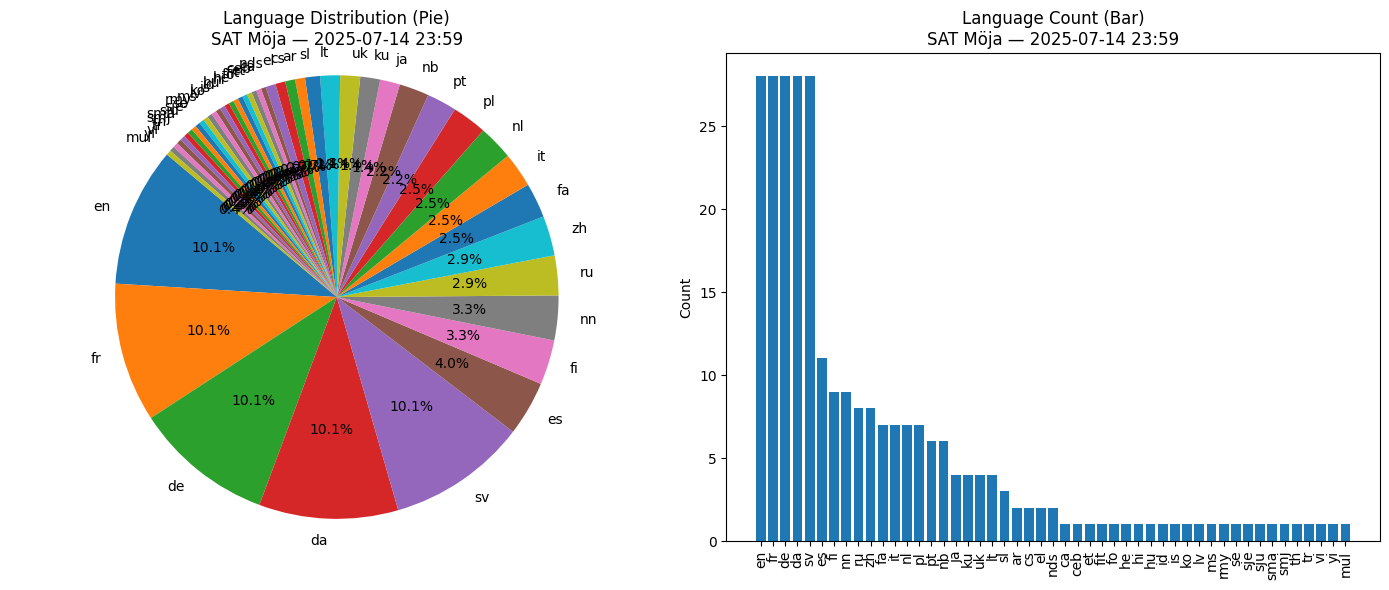

In [27]:
# Prepare data for plotting
labels = [entry["lang"] for entry in data]
sizes = [entry["count"] for entry in data]

# Current timestamp
today_str = datetime.now().strftime("%Y-%m-%d %H:%M")
title = f"{SATsection} — {today_str}"

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
ax1.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
ax1.set_title(f'Language Distribution (Pie)\n{title}')

# Bar chart
ax2.bar(labels, sizes)
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=90)
ax2.set_ylabel('Count')
ax2.set_title(f'Language Count (Bar)\n{title}')

plt.tight_layout()
plt.show()

In [4]:
import pandas as pd
from deep_translator import GoogleTranslator

## get supported languages  
langs_list = GoogleTranslator().get_supported_languages()  # output: [arabic, french, english etc...]
#langs_list

In [5]:
langs_dict = GoogleTranslator().get_supported_languages(as_dict=True)  # output: {arabic: ar, french: fr, english:en etc...}
#langs_dict

In [30]:
# https://github.com/salgo60/Stockholm_Archipelago_Trail/issues/104 
# "Test translate with use python deep_translator and create a QuickView file "
# 
# pip install sparqlwrapper
# https://rdflib.github.io/sparqlwrapper/

import sys
from SPARQLWrapper import SPARQLWrapper, JSON

today_str_filename = datetime.now().strftime("%Y-%m-%d_%H-%M")


endpoint_url = "https://query.wikidata.org/sparql"

query = """SELECT ?langValue ?item ?Lsv ?Dsv WHERE {
  VALUES ?SATSection { wd:Q133724252 } # SAT Möja
  VALUES ?langValue { "en" "fr" "de" "it" "pl" "es" "pt" "ar" "ru" "zh" "fi" 
                           "da" "nl" "ja" "fa" "uk" "lv" "lt" "cs" "hu" "el" "tr" "ko" 
                           "hi" "th" "vi" "id" "ms" "is" }

  ?item wdt:P6104 wd:Q134294510 ;
        wdt:P2789 ?SATSection ;
        rdfs:label ?Lsv ;
        schema:description ?Dsv .
  
  FILTER(LANG(?Lsv) = "sv")
  FILTER(LANG(?Dsv) = "sv")

  FILTER NOT EXISTS {
    ?item rdfs:label ?missingLabel .
    FILTER(LANG(?missingLabel) = ?langValue)
  }

  SERVICE wikibase:label { bd:serviceParam wikibase:language "sv,mul,en". }
}
ORDER BY ?item ?langValue
"""


def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

# see https://github.com/salgo60/Stockholm_Archipelago_Trail/issues/104#issuecomment-3070692372
def get_lang_code(GoogleLangCode):
    if GoogleLangCode == "zh":
        return "zh-CN"
    return GoogleLangCode



results = get_results(endpoint_url, query)
# Samla resultat
output_lines = []

from tqdm.notebook import tqdm
from deep_translator import GoogleTranslator
from datetime import datetime

# Example variables (adjust as needed)
today_str_filename = datetime.now().strftime("%Y-%m-%d_%H%M")
output_lines = []

# Loop with progress bar
for result in tqdm(results["results"]["bindings"], desc="Translating", unit="item"):
    langValue = result["langValue"]["value"]
    wd = result["item"]["value"].replace("http://www.wikidata.org/entity/", "")
    Lsv = result["Lsv"]["value"]
    Dsv = result["Dsv"]["value"]
    
    targetLangValue = get_lang_code(langValue)
    
    try:
        label_trans = GoogleTranslator(source='sv', target=targetLangValue).translate(Lsv)
        desc_trans = GoogleTranslator(source='sv', target=targetLangValue).translate(Dsv)
        
        output_lines.append(f'{wd}|L{langValue}|"{label_trans}"')
        output_lines.append(f'{wd}|D{langValue}|"{desc_trans}"')
    except Exception as e:
        print(f"❌ Översättning misslyckades för {wd} till {langValue}: {e}")

# Save to file
output_filename = f"translated_labels_descriptions_{SATsection}_{today_str_filename}.txt"
with open(output_filename, "w", encoding="utf-8") as f:
    f.write("\n".join(output_lines))

print(f"✅ Klar! Resultatet är sparat i '{output_filename}'.")


Translating:   0%|          | 0/602 [00:00<?, ?item/s]

✅ Klar! Resultatet är sparat i 'translated_labels_descriptions_SAT Möja_2025-07-15_0001.txt'.


### Next step run Quickstatement 
* https://qs-dev.toolforge.org/
* rerun stats



In [31]:
data = count_labels_by_language(
    SATsection=SATsection,
    SATwdSection=SATwdSection 
)

count_labels_by_language - params: SAT Möja / Q133724252


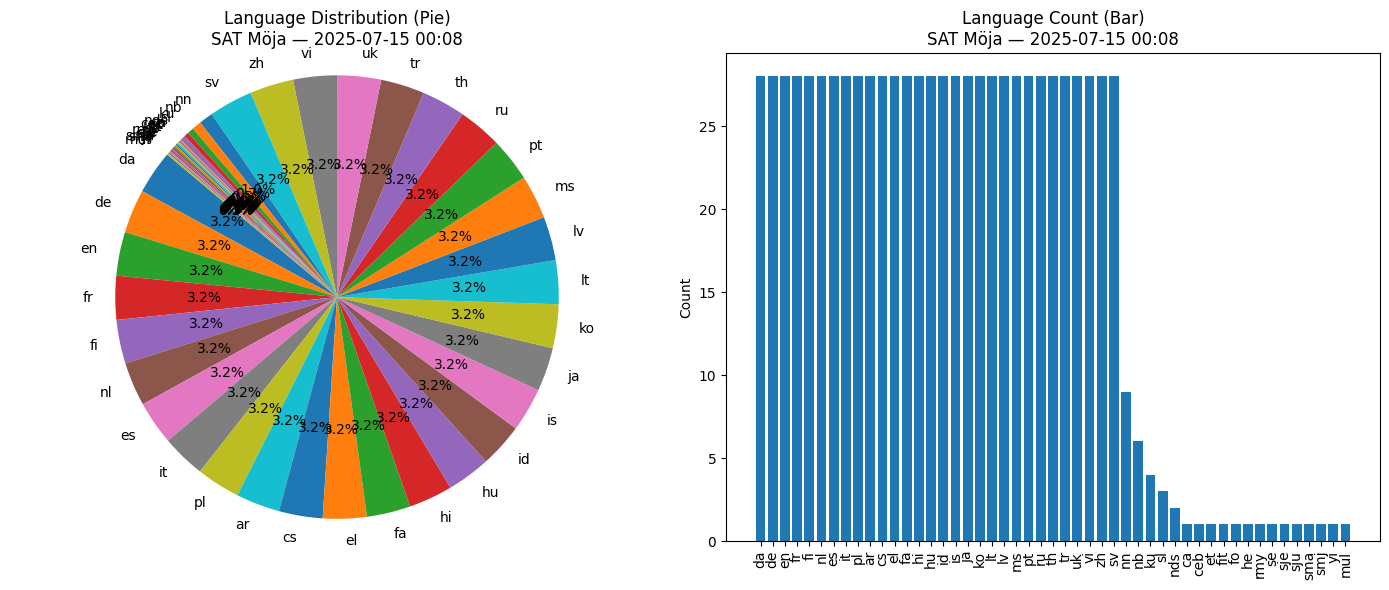

In [32]:
# Prepare data for plotting
labels = [entry["lang"] for entry in data]
sizes = [entry["count"] for entry in data]

# Current timestamp
today_str = datetime.now().strftime("%Y-%m-%d %H:%M")
title = f"{SATsection} — {today_str}"

# Create side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
ax1.axis('equal')  # Equal aspect ratio ensures pie is drawn as a circle
ax1.set_title(f'Language Distribution (Pie)\n{title}')

# Bar chart
ax2.bar(labels, sizes)
ax2.set_xticks(range(len(labels)))
ax2.set_xticklabels(labels, rotation=90)
ax2.set_ylabel('Count')
ax2.set_title(f'Language Count (Bar)\n{title}')

plt.tight_layout()
plt.show()